**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KDTree
from sklearn.model_selection import KFold

from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse.csr import csr_matrix

from math import sqrt
#%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors=n_neighbors
        self.alg=(algorithm=='brute')
    
    def fit(self, X, y):
        self.y=y
        if self.alg:
            self.x = X if type(X)==csr_matrix else X.T[np.newaxis,...]
        else:
            self.tree=KDTree(X, leaf_size=40)
    
    def predict(self, X,metric='euclidean'):
        if self.alg:
            if type(X)==csr_matrix:
                dist=pairwise_distances(X,self.x,metric=metric)
            else:
                dist=np.sqrt(((X[...,np.newaxis]-self.x)**2).sum(axis=1))
            tmp=np.argpartition(dist, self.n_neighbors,axis=-1)[:,:self.n_neighbors]
        else:
            tmp = self.tree.query(X, k=self.n_neighbors,return_distance =False)
        tmp=self.y[tmp][...,np.newaxis]
        labels=np.unique(self.y)[np.newaxis][np.newaxis]
        return labels[0,0,(labels==tmp).sum(axis=1).argmax(axis=1)]
            
    
    def predict_proba(self, X,metric='euclidean'):
        if self.alg:
            if type(X)==csr_matrix:
                dist=pairwise_distances(X,self.x,metric=metric)
            else:
                dist=np.sqrt(((X[...,np.newaxis]-self.x)**2).sum(axis=1))
            tmp=np.argpartition(dist, self.n_neighbors,axis=-1)[:,:self.n_neighbors]
        else:  
            tmp = self.tree.query(X, k=self.n_neighbors,return_distance =False)
            
        tmp=self.y[tmp][...,np.newaxis]
        labels=np.unique(self.y)[np.newaxis][np.newaxis]
        tmp= (labels==tmp).sum(axis=1)
        return tmp/tmp.sum(axis=1)[:,np.newaxis]
    
    def score(self, X, y,metric='euclidean'):
        return (self.predict(X,metric)==y).sum()/len(y)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2])

In [12]:
%time clf.predict_proba(X_test)

Wall time: 986 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 997 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 991 µs


In [18]:
%time clf.predict(X_test)

Wall time: 985 µs


array([0, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2])

In [19]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([0, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2])

In [20]:
%time clf.predict_proba(X_test)

Wall time: 999 µs


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [21]:
%time my_clf.predict_proba(X_test)

Wall time: 983 µs


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
data_tok=[]
indices=[]
for ind,line in enumerate(data):
    line=line.lower()
    tmp=list(line)
    for i, c in enumerate(line):
        if(not(c.isalpha() or c.isdigit())):
            tmp[i]=' '
    tmp=''.join(tmp).split()
    if tmp:
        data_tok.append(tmp)
        indices.append(ind)
target=target[indices]

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
from scipy.sparse import csr_matrix
indptr = [0]
indices = []
data = []
words = {}
for d in data_tok:
    data+=[1]*len(d)
    for token in d:
        index = words.setdefault(token, len(words))
        indices.append(index)
    indptr.append(len(indices))

sm=csr_matrix((data, indices, indptr), dtype=int)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
n_splits=3
kf = KFold(n_splits=n_splits,shuffle=True)

In [29]:
best_k=0
best_score=-1.0
x=[]
y=[]
for k in range(1,11):
    score_sum=0
    my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
    for train_indx,test_indx in kf.split(sm):
        my_clf.fit(sm[train_indx],target[train_indx])
        score_sum+=my_clf.score(sm[test_indx],target[test_indx])
    if score_sum/n_splits>best_score:
        best_score=score_sum/n_splits
        best_k=k
    x.append(k)
    y.append(score_sum/n_splits)

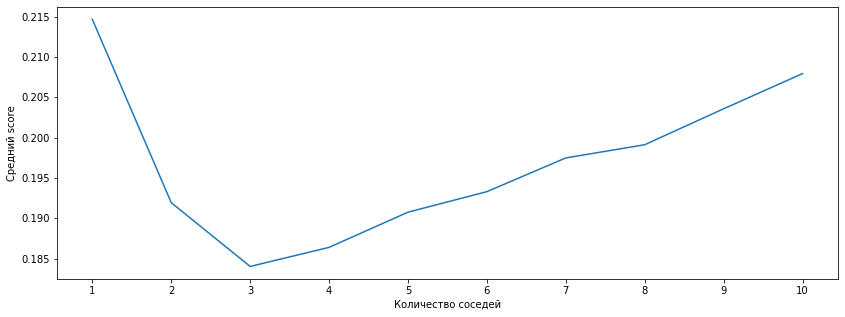

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize= (14,5))
ax=fig.add_subplot(111)
ax.set_xlabel('Количество соседей')
ax.set_ylabel('Средний score')
plt.xticks(x)
plt.plot(x,y)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [31]:
n_splits=3
kf = KFold(n_splits=n_splits,shuffle=False)

score_sum=0
my_clf = MyKNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
for train_indx,test_indx in kf.split(sm):
    my_clf.fit(sm[train_indx],target[train_indx])
    score_sum+=my_clf.score(sm[test_indx],target[test_indx])
print('default:',score_sum/n_splits)

score_sum=0
for train_indx,test_indx in kf.split(sm):
    my_clf.fit(sm[train_indx],target[train_indx])
    score_sum+=my_clf.score(sm[test_indx],target[test_indx],'cosine')
print('with cosine:',score_sum/n_splits)

from sklearn.feature_extraction.text import TfidfTransformer
tf=TfidfTransformer()
tf.fit(sm)
score_sum=0
sm_tf=tf.transform(sm)

for train_indx,test_indx in kf.split(sm_tf):
    my_clf.fit(sm_tf[train_indx],target[train_indx])
    score_sum+=my_clf.score(sm_tf[test_indx],target[test_indx])
print('with tf-idf:',score_sum/n_splits)

score_sum=0
for train_indx,test_indx in kf.split(sm_tf):
    my_clf.fit(sm_tf[train_indx],target[train_indx])
    score_sum+=my_clf.score(sm_tf[test_indx],target[test_indx],'cosine')
print('with tf-idf and cosine:',score_sum/n_splits)



default: 0.21628498727735368
with cosine: 0.28789531079607417
with tf-idf: 0.6312250090876045
with tf-idf and cosine: 0.6312250090876045


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [32]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [33]:
data_test = newsgroups['data']
target_test = newsgroups['target']

data_tok=[]
indices=[]
for ind,line in enumerate(data_test):
    line=line.lower()
    tmp=list(line)
    for i, c in enumerate(line):
        if(not(c.isalpha() or c.isdigit())):
            tmp[i]=' '
    tmp=''.join(tmp).split()
    if tmp:
        data_tok.append(tmp)
        indices.append(ind)
target_test=target_test[indices]


indptr = [0]
indices = []
data = []
for d in data_tok:
    for token in d:
        if words.get(token,-1)==-1:
            continue
        index = words[token]
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

sm_test=csr_matrix((data, indices, indptr), dtype=int)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
tf=TfidfTransformer()
tf.fit(sm)
sm_tf=tf.transform(sm)

my_clf = MyKNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
my_clf.fit(sm_tf,target)
score=my_clf.score(tf.transform(sm_test),target_test)
print('Final:',score)

Final: 0.5194965111506362


Качество score ожидаемо меньше, чем на кросс валидации. Этому есть несколько причин, например: мы обучились только лишь на ограниченном наборе данных, при этом некоторые слова, которые есть в тесте, отсутствуют в train, а значит эти слова мы попросту игнорируем.